## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [23]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1_drop): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2_drop): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=80000, out_features=500, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.5)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [26]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [41]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [38]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [39]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [40]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [31]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [32]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

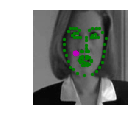

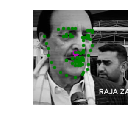

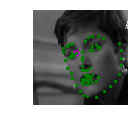

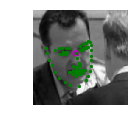

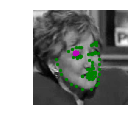

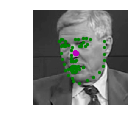

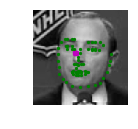

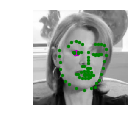

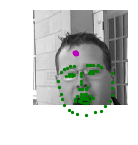

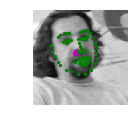

In [33]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [34]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters())


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [42]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            images, key_pts = images.to(device), key_pts.to(device)


            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_train_loss += loss.item()
        
            # if batch_i % 100 == 99:    # print every 100 batches
            #    print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/100))
            #    running_loss = 0.0
                
                
        # iterate through the test dataset
        for i, sample in enumerate(test_loader):

            # get sample data: images and ground truth keypoints
            images = sample['image']
            key_pts = sample['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert images to FloatTensors
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            images, key_pts = images.to(device), key_pts.to(device)

            # forward pass to get net output
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            epoch_test_loss += loss.item()
            
        epoch_train_loss = epoch_train_loss/len(train_loader)        
        epoch_test_loss = epoch_test_loss/len(test_loader)
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)

        print('Epoch: {}, Train Loss: {:0.6f}, Test. Loss: {:0.6f}'.format(epoch + 1, epoch_train_loss, epoch_test_loss))
    
                               
    fig = plt.figure(figsize=(18,4))
    # epoch loss
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses)
    ax.plot(test_losses)
    ax.set_title('model loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(['train', 'test'], loc='upper right')
    plt.show()

    print('Finished Training')


Epoch: 1, Train Loss: 0.126801, Test. Loss: 0.086085
Epoch: 2, Train Loss: 0.092169, Test. Loss: 0.082176
Epoch: 3, Train Loss: 0.084291, Test. Loss: 0.072026
Epoch: 4, Train Loss: 0.078740, Test. Loss: 0.066511
Epoch: 5, Train Loss: 0.068775, Test. Loss: 0.051814
Epoch: 6, Train Loss: 0.055690, Test. Loss: 0.048092
Epoch: 7, Train Loss: 0.048725, Test. Loss: 0.038165
Epoch: 8, Train Loss: 0.042884, Test. Loss: 0.041942
Epoch: 9, Train Loss: 0.041321, Test. Loss: 0.031141
Epoch: 10, Train Loss: 0.036953, Test. Loss: 0.031300
Epoch: 11, Train Loss: 0.033872, Test. Loss: 0.031421
Epoch: 12, Train Loss: 0.032895, Test. Loss: 0.029072
Epoch: 13, Train Loss: 0.030202, Test. Loss: 0.029430
Epoch: 14, Train Loss: 0.031112, Test. Loss: 0.027488
Epoch: 15, Train Loss: 0.034704, Test. Loss: 0.028670
Epoch: 16, Train Loss: 0.031308, Test. Loss: 0.026363
Epoch: 17, Train Loss: 0.028373, Test. Loss: 0.027757
Epoch: 18, Train Loss: 0.029198, Test. Loss: 0.023113
Epoch: 19, Train Loss: 0.027351, Test

Epoch: 152, Train Loss: 0.013785, Test. Loss: 0.012799
Epoch: 153, Train Loss: 0.014550, Test. Loss: 0.011553
Epoch: 154, Train Loss: 0.013357, Test. Loss: 0.016192
Epoch: 155, Train Loss: 0.014344, Test. Loss: 0.015248
Epoch: 156, Train Loss: 0.014910, Test. Loss: 0.012676
Epoch: 157, Train Loss: 0.013945, Test. Loss: 0.012857
Epoch: 158, Train Loss: 0.013142, Test. Loss: 0.012022
Epoch: 159, Train Loss: 0.014089, Test. Loss: 0.017396
Epoch: 160, Train Loss: 0.013322, Test. Loss: 0.013914
Epoch: 161, Train Loss: 0.019023, Test. Loss: 0.034702
Epoch: 162, Train Loss: 0.024726, Test. Loss: 0.015234
Epoch: 163, Train Loss: 0.016785, Test. Loss: 0.013961
Epoch: 164, Train Loss: 0.014343, Test. Loss: 0.016065
Epoch: 165, Train Loss: 0.013462, Test. Loss: 0.014821
Epoch: 166, Train Loss: 0.012721, Test. Loss: 0.012445
Epoch: 167, Train Loss: 0.013141, Test. Loss: 0.011306
Epoch: 168, Train Loss: 0.013532, Test. Loss: 0.012503
Epoch: 169, Train Loss: 0.012481, Test. Loss: 0.011211
Epoch: 170

Epoch: 301, Train Loss: 0.012176, Test. Loss: 0.012050
Epoch: 302, Train Loss: 0.012309, Test. Loss: 0.010670
Epoch: 303, Train Loss: 0.011527, Test. Loss: 0.012974
Epoch: 304, Train Loss: 0.011936, Test. Loss: 0.011807
Epoch: 305, Train Loss: 0.012662, Test. Loss: 0.011651
Epoch: 306, Train Loss: 0.011996, Test. Loss: 0.011739
Epoch: 307, Train Loss: 0.011352, Test. Loss: 0.010620
Epoch: 308, Train Loss: 0.012683, Test. Loss: 0.012934
Epoch: 309, Train Loss: 0.015759, Test. Loss: 0.012911
Epoch: 310, Train Loss: 0.014175, Test. Loss: 0.011907
Epoch: 311, Train Loss: 0.012657, Test. Loss: 0.010944
Epoch: 312, Train Loss: 0.012692, Test. Loss: 0.013977
Epoch: 313, Train Loss: 0.011727, Test. Loss: 0.013486
Epoch: 314, Train Loss: 0.013517, Test. Loss: 0.012042
Epoch: 315, Train Loss: 0.011746, Test. Loss: 0.014236
Epoch: 316, Train Loss: 0.012609, Test. Loss: 0.010223
Epoch: 317, Train Loss: 0.013335, Test. Loss: 0.011848
Epoch: 318, Train Loss: 0.011995, Test. Loss: 0.014173
Epoch: 319

Epoch: 450, Train Loss: 0.011495, Test. Loss: 0.012502
Epoch: 451, Train Loss: 0.010911, Test. Loss: 0.011837
Epoch: 452, Train Loss: 0.011260, Test. Loss: 0.010857
Epoch: 453, Train Loss: 0.011912, Test. Loss: 0.011436
Epoch: 454, Train Loss: 0.011538, Test. Loss: 0.010609
Epoch: 455, Train Loss: 0.010344, Test. Loss: 0.011065
Epoch: 456, Train Loss: 0.010382, Test. Loss: 0.009958
Epoch: 457, Train Loss: 0.010799, Test. Loss: 0.011222
Epoch: 458, Train Loss: 0.011602, Test. Loss: 0.010111
Epoch: 459, Train Loss: 0.011186, Test. Loss: 0.011922
Epoch: 460, Train Loss: 0.010803, Test. Loss: 0.010338
Epoch: 461, Train Loss: 0.010893, Test. Loss: 0.010492
Epoch: 462, Train Loss: 0.011533, Test. Loss: 0.009892
Epoch: 463, Train Loss: 0.010875, Test. Loss: 0.011772
Epoch: 464, Train Loss: 0.010678, Test. Loss: 0.009888
Epoch: 465, Train Loss: 0.011196, Test. Loss: 0.010363
Epoch: 466, Train Loss: 0.013881, Test. Loss: 0.010827
Epoch: 467, Train Loss: 0.011890, Test. Loss: 0.011263
Epoch: 468

Epoch: 599, Train Loss: 0.010044, Test. Loss: 0.009326
Epoch: 600, Train Loss: 0.010217, Test. Loss: 0.008600
Epoch: 601, Train Loss: 0.010804, Test. Loss: 0.010656
Epoch: 602, Train Loss: 0.010636, Test. Loss: 0.009372
Epoch: 603, Train Loss: 0.010379, Test. Loss: 0.009676
Epoch: 604, Train Loss: 0.010858, Test. Loss: 0.010955
Epoch: 605, Train Loss: 0.010694, Test. Loss: 0.009661
Epoch: 606, Train Loss: 0.011355, Test. Loss: 0.013062
Epoch: 607, Train Loss: 0.011283, Test. Loss: 0.010822
Epoch: 608, Train Loss: 0.010957, Test. Loss: 0.012551
Epoch: 609, Train Loss: 0.010232, Test. Loss: 0.010477
Epoch: 610, Train Loss: 0.010470, Test. Loss: 0.010589
Epoch: 611, Train Loss: 0.011817, Test. Loss: 0.010250
Epoch: 612, Train Loss: 0.010308, Test. Loss: 0.010677
Epoch: 613, Train Loss: 0.010915, Test. Loss: 0.009145
Epoch: 614, Train Loss: 0.010330, Test. Loss: 0.010290
Epoch: 615, Train Loss: 0.010455, Test. Loss: 0.011650
Epoch: 616, Train Loss: 0.011863, Test. Loss: 0.009659
Epoch: 617

Epoch: 748, Train Loss: 0.010397, Test. Loss: 0.009424
Epoch: 749, Train Loss: 0.009832, Test. Loss: 0.009780
Epoch: 750, Train Loss: 0.009858, Test. Loss: 0.010315
Epoch: 751, Train Loss: 0.010280, Test. Loss: 0.010184
Epoch: 752, Train Loss: 0.010144, Test. Loss: 0.010216
Epoch: 753, Train Loss: 0.009550, Test. Loss: 0.010855
Epoch: 754, Train Loss: 0.009919, Test. Loss: 0.010255
Epoch: 755, Train Loss: 0.009206, Test. Loss: 0.009160
Epoch: 756, Train Loss: 0.010688, Test. Loss: 0.011441
Epoch: 757, Train Loss: 0.010771, Test. Loss: 0.012305
Epoch: 758, Train Loss: 0.011272, Test. Loss: 0.010408
Epoch: 759, Train Loss: 0.010126, Test. Loss: 0.010422
Epoch: 760, Train Loss: 0.010425, Test. Loss: 0.011108
Epoch: 761, Train Loss: 0.010693, Test. Loss: 0.010039
Epoch: 762, Train Loss: 0.010474, Test. Loss: 0.010706
Epoch: 763, Train Loss: 0.011176, Test. Loss: 0.011019
Epoch: 764, Train Loss: 0.011189, Test. Loss: 0.009457
Epoch: 765, Train Loss: 0.010935, Test. Loss: 0.009740
Epoch: 766

Epoch: 897, Train Loss: 0.011005, Test. Loss: 0.013261
Epoch: 898, Train Loss: 0.010928, Test. Loss: 0.011231
Epoch: 899, Train Loss: 0.012099, Test. Loss: 0.009899
Epoch: 900, Train Loss: 0.010147, Test. Loss: 0.009344
Epoch: 901, Train Loss: 0.010141, Test. Loss: 0.009821
Epoch: 902, Train Loss: 0.010071, Test. Loss: 0.009909
Epoch: 903, Train Loss: 0.009924, Test. Loss: 0.012256
Epoch: 904, Train Loss: 0.010166, Test. Loss: 0.010669
Epoch: 905, Train Loss: 0.010446, Test. Loss: 0.012312
Epoch: 906, Train Loss: 0.010689, Test. Loss: 0.009990
Epoch: 907, Train Loss: 0.009919, Test. Loss: 0.008973
Epoch: 908, Train Loss: 0.010461, Test. Loss: 0.009745
Epoch: 909, Train Loss: 0.009953, Test. Loss: 0.009616
Epoch: 910, Train Loss: 0.011055, Test. Loss: 0.009707
Epoch: 911, Train Loss: 0.009617, Test. Loss: 0.009631
Epoch: 912, Train Loss: 0.009974, Test. Loss: 0.009848
Epoch: 913, Train Loss: 0.011191, Test. Loss: 0.011327
Epoch: 914, Train Loss: 0.009857, Test. Loss: 0.008187
Epoch: 915

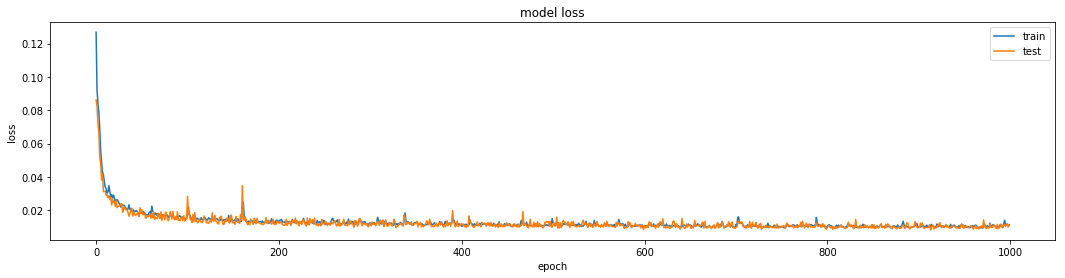

Finished Training


In [43]:
# train your network
n_epochs = 1000 # start small, and increase when you've decided on your model structure and hyperparams

net.to(device)
train_net(n_epochs)

In [44]:
net.to(cpu)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1_drop): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2_drop): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=80000, out_features=500, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.5)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [45]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


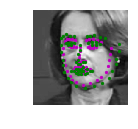

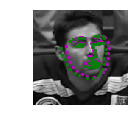

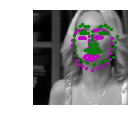

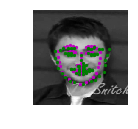

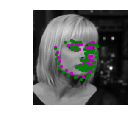

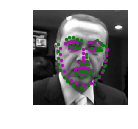

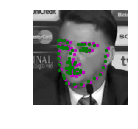

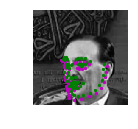

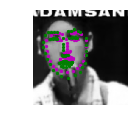

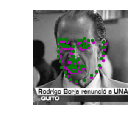

In [46]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [47]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_7.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

I used `nn.MSELoss()` (mean squared error) - as this problem is to determine the location of point, hence I have a feeling mean squared error will do the job. (the loss function calculate the distance from the prediction to the truth label)

`Adam` is chosen as the optimizer, as it include Momentum, which I quite like the idea.


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

- Model1: Try first with convolution layers with reducing number of filters: 32 -> 16 -> 8 (this probably not a good idea since we loose information)

- Model2: Tried to remove dropout to see the effect - but not much

- Model3: start big from 256 -> 128 -> 64 - but also didn't help

- Model4: Start looking into the paper, realized that we need to increase the number of filters deeper in the conv layers. So I try 32 -> 64 -> 128 -> 256. Also increase epochs to 20. Models seems still overfitting.

- Model5: An interesting idea from the paper is that they added Dropout after each convolution layer (I thought we can only use Dropout for Linear, but apparently we can use it everywhere). Still not doing very well on test set

- Model6: increase batch_size to 50, don't know why but it helps, got better visualization on test set.

Model1: 
```
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5000, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)

Epoch: 5, Batch: 10, Avg. Loss: 0.0012796485275030137
Epoch: 5, Batch: 20, Avg. Loss: 0.0008916759938001632
Epoch: 5, Batch: 30, Avg. Loss: 0.0011363276541233062
Epoch: 5, Batch: 40, Avg. Loss: 0.0014630163237452508
Epoch: 5, Batch: 50, Avg. Loss: 0.001067170739173889
Epoch: 5, Batch: 60, Avg. Loss: 0.000944077268242836
Epoch: 5, Batch: 70, Avg. Loss: 0.0010995522513985634
Epoch: 5, Batch: 80, Avg. Loss: 0.0010568780787289143
Epoch: 5, Batch: 90, Avg. Loss: 0.0010917553193867207
Epoch: 5, Batch: 100, Avg. Loss: 0.002558537669479847
Epoch: 5, Batch: 110, Avg. Loss: 0.0010964079946279527
Epoch: 5, Batch: 120, Avg. Loss: 0.0008290128745138645
Epoch: 5, Batch: 130, Avg. Loss: 0.000993598286062479
Epoch: 5, Batch: 140, Avg. Loss: 0.0010901359170675277
Epoch: 5, Batch: 150, Avg. Loss: 0.001186748668551445
```


Model2:

```
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)

Not as good on test set

Epoch: 5, Batch: 100, Avg. Loss: 0.08471451066434384
Epoch: 5, Batch: 110, Avg. Loss: 0.08308817725628614
Epoch: 5, Batch: 120, Avg. Loss: 0.0869146816432476
Epoch: 5, Batch: 130, Avg. Loss: 0.08553049471229315
Epoch: 5, Batch: 140, Avg. Loss: 0.08508358970284462
Epoch: 5, Batch: 150, Avg. Loss: 0.08642560765147209
Epoch: 5, Batch: 160, Avg. Loss: 0.08469461221247912
Epoch: 5, Batch: 170, Avg. Loss: 0.12220065779983998
Epoch: 5, Batch: 180, Avg. Loss: 0.10561736337840558
Epoch: 5, Batch: 190, Avg. Loss: 0.13724560085684062
Epoch: 5, Batch: 200, Avg. Loss: 0.12320423237979412
Epoch: 5, Batch: 210, Avg. Loss: 0.11007626205682755


```

Model3 : massive increase convolution filter size initially but doesn't help much, visualization still quite wrong

```
Net(
  (conv1): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40000, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
)

Epoch: 5, Batch: 60, Avg. Loss: 0.10539185032248496
Epoch: 5, Batch: 70, Avg. Loss: 0.12226291969418526
Epoch: 5, Batch: 80, Avg. Loss: 0.11260554417967797
Epoch: 5, Batch: 90, Avg. Loss: 0.12445151060819626
Epoch: 5, Batch: 100, Avg. Loss: 0.1367290236055851
Epoch: 5, Batch: 110, Avg. Loss: 0.14138125702738763
Epoch: 5, Batch: 120, Avg. Loss: 0.10507472082972527
Epoch: 5, Batch: 130, Avg. Loss: 0.1182007797062397
Epoch: 5, Batch: 140, Avg. Loss: 0.10693984404206276
Epoch: 5, Batch: 150, Avg. Loss: 0.19277514293789863
Epoch: 5, Batch: 160, Avg. Loss: 0.13020153269171714
Epoch: 5, Batch: 170, Avg. Loss: 0.10954335406422615
Epoch: 5, Batch: 180, Avg. Loss: 0.08828600719571114
Epoch: 5, Batch: 190, Avg. Loss: 0.11367425993084908
Epoch: 5, Batch: 200, Avg. Loss: 0.08680138364434242
Epoch: 5, Batch: 210, Avg. Loss: 0.08599894233047962
```


Model 4: more align with the paper: 4 conv layers, with layers size from 32 --> 256

```
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30976, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2_drop): Dropout(p=0.5)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

But still seems to overfit the training data, visualization still wrong after 5 epochs
```

Model 5: adding dropout for after each conv2d layer, increase epochs to 20

```
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1_drop): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2_drop): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3_drop): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4_drop): Dropout(p=0.4)
  (fc1): Linear(in_features=30976, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2_drop): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)
```


Model 6: keep model 5, increase batch_size to 50 for training, seems like it helps

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

I started small with epochs and stay at epochs=5 for most model... The error rate is decreasing so that I know my model is learning something. 

However, the prediction on the test set is quite badly until the Model 6.

Model6 with epochs=5, the prediction on the test set is still wrong, but at least it have the correct shape...

I tried to increase epochs=20, but still not getting good result.

I tried to increase training batch_size=50, and the result's looking better.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset
# iterate through the test dataset
dataiter = iter(test_loader)
data = dataiter.next()
images = data['image']

images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

filtered = cv2.filter2D(img, -1, w[0][0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('original')
ax1.imshow(img, cmap='gray')

ax2.set_title('filtered')
ax2.imshow(filtered, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) 

Seems like it converts the image to negative image ...

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!